# Libraries & Settings

In [1]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import qgrid
from datetime import datetime as dtt

from pa_lib.file import data_files, load_bin, store_bin, load_csv, write_xlsx, load_xlsx
from pa_lib.data import (
    calc_col_partitioned,
    clean_up_categoricals,
    flatten,
    replace_col,
    cond_col,
    desc_col,
    unfactorize,
    as_dtype,
    flatten_multi_index_cols,
)
from pa_lib.util import obj_size, cap_words
from pa_lib.log import time_log, info
from pa_lib.vis import dive

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)


def qshow(df, fit_width=False):
    return qgrid.show_grid(
        df, grid_options={"forceFitColumns": fit_width, "fullWidthRows": False}
    )

# Load data

In [2]:
bd_raw = load_bin("bd_data.feather").rename(
    mapper=lambda name: cap_words(name, sep="_"), axis="columns"
)
bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)

2019-08-12 12:25:27 [INFO] Reading from file C:\Users\kpf\data\bd_data.feather
C:\ProgramData\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
2019-08-12 12:25:28 [INFO] Finished loading binary file in 0.19s (0.52s CPU)


In [3]:
desc_col(bd)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,category,0/662686,31777
Endkunde,category,0/662686,29880
EK_Abc,category,1161/661525,8
EK_Boni,category,76/662610,3
EK_Plz,category,155/662531,2958
EK_Ort,category,155/662531,3006
EK_Land,category,155/662531,46
EK_HB_Apg_Kurzz,category,27195/635491,83
EK_Aktiv,category,0/662686,2
Agentur,category,316433/346253,3908


# Prepare Endkunden Information

In [4]:
def last_notna(s):
    try:
        return s.loc[s.notna()].iat[-1]
    except IndexError:
        return np.NaN


def collect(s, sep=", "):
    return sep.join(map(str, s[s.notna()].unique()))


# this takes around 150 seconds
with time_log("preparing EK_INFO"):
    ek_info = (
        bd.sort_values(["Endkunde_NR", "Kampagne_Erfassungsdatum"])
        .astype({"Endkunde_NR": "int64", "Kamp_Erfass_Jahr": "int16"})
        .groupby("Endkunde_NR")
        .agg(
            {
                "Endkunde": last_notna,
                "EK_Aktiv": last_notna,
                "EK_Land": last_notna,
                "EK_Plz": last_notna,
                "EK_Ort": last_notna,
                "Agentur": last_notna,
                "Endkunde_Branchengruppe": last_notna,
                "Endkunde_Branchengruppe_ID": last_notna,
                "Auftrag_Branchengruppe_ID": [collect, "nunique"],
                "Kamp_Erfass_Jahr": ["min", "max"],
            }
        )
    )

ek_info.set_axis(
    labels="Endkunde EK_Aktiv EK_Land EK_Plz EK_Ort Agentur EK_BG EK_BG_ID Auftrag_BG_ID Auftrag_BG_Anz Kamp_Erfass_Jahr_min Kamp_Erfass_Jahr_max".split(),
    axis="columns",
    inplace=True,
)

2019-08-12 12:27:38 [INFO] Finished preparing EK_INFO in 117.52s (118.55s CPU)


### How many customers started or ended in which year?

In [5]:
pd.crosstab(
    index=ek_info.Kamp_Erfass_Jahr_min,
    columns=ek_info.Kamp_Erfass_Jahr_max,
    margins=True,
)

Kamp_Erfass_Jahr_max,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Kamp_Erfass_Jahr_min,,,,,,,,,,,,,
2007,0,3,0,0,1,0,1,0,0,0,2,2,9
2008,265,145,105,85,84,93,98,117,115,98,325,588,2118
2009,0,1614,510,346,295,305,258,300,260,279,693,1158,6018
2010,0,0,1242,275,186,145,127,131,100,128,260,337,2931
2011,0,0,0,1309,244,173,136,167,126,131,232,343,2861
2012,0,0,0,0,1121,228,150,146,164,114,194,252,2369
2013,0,0,0,0,0,1128,261,162,146,141,226,265,2329
2014,0,0,0,0,0,0,1181,265,183,142,279,308,2358
2015,0,0,0,0,0,0,0,1369,279,203,288,299,2438


### Store and reload result

In [6]:
store_bin(ek_info, "bd_cluster_ek_info.feather")

2019-08-12 12:27:58 [INFO] Writing to file C:\Users\kpf\data\bd_cluster_ek_info.feather
2019-08-12 12:27:58 [INFO] Written 4.1 MB
2019-08-12 12:27:58 [INFO] Finished storing binary file in 0.03s (0.03s CPU)


In [7]:
ek_info = load_bin('bd_cluster_ek_info.feather')

2019-08-12 12:27:59 [INFO] Reading from file C:\Users\kpf\data\bd_cluster_ek_info.feather
2019-08-12 12:27:59 [INFO] Finished loading binary file in 0.02s (0.02s CPU)


# Distribution of Auftragsart vs. Vertrag

In [8]:
display(
    pd.crosstab(
        index=[bd.Auftragsart, bd.Vertrag], columns=bd.Kamp_Erfass_Jahr, margins=True
    )
)
display("Netto-Umsatz")
display(
    bd.pivot_table(
        index=["Auftragsart", "Vertrag"],
        columns="Kamp_Erfass_Jahr",
        values="Netto",
        aggfunc="sum",
        fill_value=0,
        margins=True,
    )
)

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,88,2003,1629,1745,2223,2703,1488,26,14,16,21,13,11969
Eigenwerbung APG,Nein,0,0,79,0,1,13,0,1,123,56,82,56,0,411
Goodwill,Nein,0,0,6,7,6,9,9,5,6,4,12,13,8,85
Karitativ,Nein,0,104,227,238,224,351,265,304,442,564,547,598,406,4270
Kommerziell,Nein,0,6078,34516,38627,39748,37761,36611,40953,43260,48152,50064,49006,33807,458583
Logistik für Dritte,Nein,0,0,0,0,4,13,6,31,387,353,371,378,190,1733
Politisch,Nein,0,354,1934,1773,4847,3068,2492,2733,5842,3536,3106,3275,3825,36785
Promotion,Nein,0,60,2283,1879,1728,1823,3048,1212,2102,2736,2965,3854,680,24370
Sponsoring,Nein,0,40,139,124,179,181,171,172,218,208,245,358,76,2111


'Netto-Umsatz'

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,30444,849600,791206,739514,1026394,1000669,439344,110412,92214,117954,150966,72198,5420915
Eigenwerbung APG,Nein,0,0,3897655,0,4670,1048532,0,360,133390,126540,1222454,72427,0,6506028
Goodwill,Nein,0,0,6543,7939,4953,18668,2994,4762,4191,1732,17772,16741,5925,92220
Karitativ,Nein,0,724644,1960077,1628917,1866012,2668615,2253943,2318474,2578634,3459117,2775404,3962032,2632140,28828009
Kommerziell,Nein,0,33806952,148051046,162393013,168628594,175031787,158519973,182560236,193519765,204222602,197001081,191949492,145654263,1961338804
Logistik für Dritte,Nein,0,0,0,0,4600,184578,31589,132394,479850,420927,418245,522661,239121,2433965
Politisch,Nein,0,2040430,6938949,6463858,18562173,11082670,9945225,10458567,16977360,11414298,6379246,8489070,10458705,119210551
Promotion,Nein,0,1083041,5375644,4376195,3393104,3505266,5451654,3185928,3787542,4991362,4881049,9304271,1960374,51295430
Sponsoring,Nein,0,348746,1097029,1087749,2340803,2588788,3282531,3450304,3740079,3906123,3671259,3432667,438138,29384216


# Restrict bookings to interesting customers (current & long-term)

### List of current long-time customers

* "Current" means that their last booking was not more than two years back. 
* "Long-time" means that they had at least two years of bookings.

In [9]:
limit_year = pd.Timestamp.today().year - 2

ek_nr_current = ek_info.loc[
    (ek_info.Kamp_Erfass_Jahr_max >= limit_year)
    & (ek_info.Kamp_Erfass_Jahr_min < limit_year - 2),
    "Endkunde_NR"
]

In [10]:
bd_current = bd.loc[bd.Endkunde_NR.isin(ek_nr_current)].pipe(clean_up_categoricals)

# Aggregate bookings per customer, year, and KW_2 / KW_4 period

Both by Reservation and Aushang.

In [11]:
def sum_calc(df, col_year, col_week):
    return (
        df.loc[:, ["Endkunde_NR", col_year, col_week, "Netto"]]
        .pipe(unfactorize)
        .groupby(["Endkunde_NR", col_year, col_week], observed=True, as_index=False)
        .agg({"Netto": ["sum"]})
        .set_axis(
            f"Endkunde_NR {col_year} {col_week} Netto_Sum".split(),
            axis="columns",
            inplace=False,
        )
    )


def aggregate_bookings(df, period):
    info(f"Period: {period}")
    info("Calculate Reservation...")
    df_res = sum_calc(df, "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}")
    info("Calculate Aushang...")
    df_aus = sum_calc(df, "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}")

    info("Merge Results...")
    df_aggr = df_res.merge(
        right=df_aus,
        left_on=["Endkunde_NR", "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}"],
        right_on=["Endkunde_NR", "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"],
        how="outer",
        suffixes=("_Res", "_Aus"),
    ).rename(
        {"Kamp_Erfass_Jahr": "Jahr", f"Kamp_Erfass_{period}": period}, axis="columns"
    )

    df_aggr = (
        df_aggr.fillna(
            {
                "Jahr": df_aggr.Kamp_Beginn_Jahr,
                period: df_aggr[f"Kamp_Beginn_{period}"],
                "Netto_Sum_Res": 0,
                "Netto_Sum_Aus": 0,
            }
        )
        .drop(["Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"], axis="columns")
        .astype({"Jahr": "int16"})
        .astype({period: "int8"})
        .sort_values(["Jahr", "Endkunde_NR", period])
        .reset_index(drop=True)
    )

    return df_aggr

In [12]:
bd_aggr_2w = aggregate_bookings(bd_current, 'KW_2')
bd_aggr_4w = aggregate_bookings(bd_current, 'KW_4')

2019-08-12 12:29:02 [INFO] Period: KW_2
2019-08-12 12:29:02 [INFO] Calculate Reservation...
2019-08-12 12:29:02 [INFO] Calculate Aushang...
2019-08-12 12:29:02 [INFO] Merge Results...
2019-08-12 12:29:03 [INFO] Period: KW_4
2019-08-12 12:29:03 [INFO] Calculate Reservation...
2019-08-12 12:29:03 [INFO] Calculate Aushang...
2019-08-12 12:29:03 [INFO] Merge Results...


In [13]:
bd_aggr_2w.head(10)

,Endkunde_NR,Jahr,KW_2,Netto_Sum_Res,Netto_Sum_Aus
0,103092,2007,45,5310.0,0.0
1,116266,2007,23,5700.0,0.0
2,177225,2007,45,2365.0,0.0
3,494878,2007,47,5900.0,0.0
4,100098,2008,39,16755.0,0.0
5,100143,2008,39,15000.0,0.0
6,100143,2008,49,2560.0,0.0
7,100166,2008,47,1007.0,0.0
8,100166,2008,49,40823.0,0.0
9,100166,2008,51,10431.0,1007.0


### Calculate sum curve per customer * year, over periods

In [14]:
def make_year_grp_sumcurve(df, year_col, grp_col, data_col, prefix=''):
    # build new columns with sum/cumsum per year/grp
    df = (df
          .pipe(calc_col_partitioned, f'{prefix}sumJahr', fun='sum',    on=data_col, part_by=[year_col, grp_col])
          .pipe(calc_col_partitioned, f'{prefix}cumJahr', fun='cumsum', on=data_col, part_by=[year_col, grp_col]))

    # divide data_col by sum to get scaled amounts, show in %
    df = (df.eval(f'{prefix}prcJahr = ({data_col} / {prefix}sumJahr) * 100 + 0.5')
            .fillna({f'{prefix}prcJahr': 0})
            .astype({f'{prefix}prcJahr': 'int'}))

    # divide cumsum by sum to get sum curve [0, 1], show in %
    df = (df.eval(f'{prefix}crvJahr = ({prefix}cumJahr / {prefix}sumJahr) * 100 + 0.5')
            .fillna({f'{prefix}crvJahr': 0})
            .astype({f'{prefix}crvJahr': 'int'}))
    return df

In [15]:
bd_aggr_2w = (
    bd_aggr_2w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_2"])
    .reset_index(drop=True)
)

bd_aggr_4w = (
    bd_aggr_4w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_4"])
    .reset_index(drop=True)
)

In [16]:
bd_aggr_2w.head(10)

,Endkunde_NR,Jahr,KW_2,Netto_Sum_Res,Netto_Sum_Aus,Res_sumJahr,Res_cumJahr,Res_prcJahr,Res_crvJahr,Aus_sumJahr,Aus_cumJahr,Aus_prcJahr,Aus_crvJahr
0,100034,2009,7,21834.0,0.0,66453.0,21834.0,33,33,66453.0,0.0,0,0
1,100034,2009,9,1400.0,0.0,66453.0,23234.0,2,35,66453.0,0.0,0,0
2,100034,2009,13,0.0,23234.0,66453.0,23234.0,0,35,66453.0,23234.0,35,35
3,100034,2009,17,3933.0,0.0,66453.0,27167.0,6,41,66453.0,23234.0,0,35
4,100034,2009,23,0.0,3933.0,66453.0,27167.0,0,41,66453.0,27167.0,6,41
5,100034,2009,39,9000.0,0.0,66453.0,36167.0,14,54,66453.0,27167.0,0,41
6,100034,2009,43,3770.0,9000.0,66453.0,39937.0,6,60,66453.0,36167.0,14,54
7,100034,2009,45,26516.0,0.0,66453.0,66453.0,40,100,66453.0,36167.0,0,54
8,100034,2009,47,0.0,30286.0,66453.0,66453.0,0,100,66453.0,66453.0,46,100
9,100034,2010,9,22495.0,0.0,72769.0,22495.0,31,31,72769.0,0.0,0,0


In [17]:
bd_aggr_4w.head(10)

,Endkunde_NR,Jahr,KW_4,Netto_Sum_Res,Netto_Sum_Aus,Res_sumJahr,Res_cumJahr,Res_prcJahr,Res_crvJahr,Aus_sumJahr,Aus_cumJahr,Aus_prcJahr,Aus_crvJahr
0,100034,2009,5,21834.0,0.0,66453.0,21834.0,33,33,66453.0,0.0,0,0
1,100034,2009,9,1400.0,0.0,66453.0,23234.0,2,35,66453.0,0.0,0,0
2,100034,2009,13,0.0,23234.0,66453.0,23234.0,0,35,66453.0,23234.0,35,35
3,100034,2009,17,3933.0,0.0,66453.0,27167.0,6,41,66453.0,23234.0,0,35
4,100034,2009,21,0.0,3933.0,66453.0,27167.0,0,41,66453.0,27167.0,6,41
5,100034,2009,37,9000.0,0.0,66453.0,36167.0,14,54,66453.0,27167.0,0,41
6,100034,2009,41,3770.0,9000.0,66453.0,39937.0,6,60,66453.0,36167.0,14,54
7,100034,2009,45,26516.0,30286.0,66453.0,66453.0,40,100,66453.0,66453.0,46,100
8,100034,2010,9,22495.0,0.0,72769.0,22495.0,31,31,72769.0,0.0,0,0
9,100034,2010,13,0.0,22495.0,72769.0,22495.0,0,31,72769.0,22495.0,31,31


### Store and reload results

In [18]:
store_bin(bd_aggr_2w, 'bd_cluster_aggr_2w.feather')
store_bin(bd_aggr_4w, 'bd_cluster_aggr_4w.feather')

2019-08-12 12:29:33 [INFO] Writing to file C:\Users\kpf\data\bd_cluster_aggr_2w.feather
2019-08-12 12:29:33 [INFO] Written 13.7 MB
2019-08-12 12:29:33 [INFO] Finished storing binary file in 0.02s (0.19s CPU)
2019-08-12 12:29:33 [INFO] Writing to file C:\Users\kpf\data\bd_cluster_aggr_4w.feather
2019-08-12 12:29:33 [INFO] Written 11.9 MB
2019-08-12 12:29:33 [INFO] Finished storing binary file in 0.02s (0.09s CPU)


In [19]:
bd_aggr_2w = load_bin('bd_cluster_aggr_2w.feather')
bd_aggr_4w = load_bin('bd_cluster_aggr_4w.feather')

2019-08-12 12:29:34 [INFO] Reading from file C:\Users\kpf\data\bd_cluster_aggr_2w.feather
C:\ProgramData\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
2019-08-12 12:29:34 [INFO] Finished loading binary file in 0.01s (0.0s CPU)
2019-08-12 12:29:34 [INFO] Reading from file C:\Users\kpf\data\bd_cluster_aggr_4w.feather
2019-08-12 12:29:34 [INFO] Finished loading binary file in 0.01s (0.16s CPU)


# Clustering by Reservation

### Drop incomplete years

We have data for the last 10 years, the current year is incomplete

In [20]:
valid_years = list(range(pd.Timestamp.today().year - 10, pd.Timestamp.today().year))
valid_years

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

### Prepare data: Pivot prc values by period

In [21]:
bd_res_prc_2w_data = bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))].pivot_table(
    index=["Endkunde_NR", "Jahr"],
    columns="KW_2",
    values="Res_prcJahr",
    aggfunc="sum",
    fill_value=0,
)

bd_res_prc_2w_data.head(12)

KW_2              1   3   5   7   9   11  13  15  17  19  21  23  25  27  29  \
Endkunde_NR Jahr                                                               
100034      2009   0   0   0  33   2   0   0   0   6   0   0   0   0   0   0   
            2010   0   0   0   0  31   0   0   0   0   0   0   0   0   0  12   
            2011   0   0   0   0  40   0   0   0   0   0   0   0   0   0   0   
            2012   0   0   0   0  29   0   0   0   0   0   0   0   0   0   8   
            2013   0   0  52   2   0   0   0   0   0   0   0   0   0   0   0   
            2014   0  40   2   0   0   0   0   0   0   0   0   0   0   0   0   
            2015   0   0  44   0   0   0   0   0   0   0   0   0   0   0   0   
            2016   0  57   0   0   0   0   0   0   0   0   0   0   0   0   0   
            2017   0   0  28   0   0   0   0   0   0   0   0   0   0   0   0   
            2018   0   0  26   0   0   0   0   0   0   0   0   0   0   0   0   
100039      2009  23   0   0   0   0   0  55   0   0   0   0   0   0   0   0   
            2010   0   0   0   0   0   0   0   0  55   0   0   0   0   0   0   

KW_2              31  33  35  37  39  41  43  45  47  49  51  
Endkunde_NR Jahr                                              
100034      2009   0   0   0   0  14   0   6  40   0   0   0  
            2010   0   0   0   0   0   0  57   0   0   0   0  
            2011  14   0   0   0   4   2  41   0   0   0   0  
            2012   9   0   0   0   0   0  51   2   0   0   0  
            2013  14   0   0   0   0   0  32   0   0   0   0  
            2014   0   0   0   0   0   0  58   0   0   0   0  
            2015   0   0   0   0   0   0  51   5   0   0   0  
            2016   0   0   0   0   0  39   4   0   0   0   0  
            2017   0   0   0   0   0  26  47   0   0   0   0  
            2018   0   0   0   0   0   0  74   0   0   0   0  
100039      2009   0   0   0   0   0   0   0   0   0   0  23  
            2010   0   0   0   0   0   0   0   0   0   0  45

### Prepare data: Aggregate over years by customer

In [82]:
ek_2w_prc_mean = (
    bd_res_prc_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

ek_2w_prc_mean_stack = (
    ek_2w_prc_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "prc_mean"], axis="columns", inplace=False)
)

display(ek_2w_prc_mean.head(10))

KW_2,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51
Endkunde_NR,,,,,,,,,,,,,,,,,,,,,,,,,,
100034,0.00,9.7,15.2,3.5,10.200000,0.0,0.000000,0.0,0.6,0.0,0.0,0.0,0.000000,0.0,2.0,3.7,0.000000,0.000000,0.000000,1.8,6.700000,42.100000,4.7,0.000000,0.000000,0.0
100039,2.30,5.3,0.0,0.0,4.200000,8.8,11.200000,8.5,5.5,0.0,0.0,3.1,0.000000,0.0,0.0,8.9,0.000000,16.800000,0.000000,0.0,0.000000,0.000000,12.7,2.600000,2.200000,8.0
100064,0.00,0.0,0.0,0.0,11.111111,0.0,83.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,5.777778,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
100066,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,33.333333,0.0,0.000000,0.000000,0.0,33.333333,0.000000,0.0
100083,9.25,0.0,0.0,25.0,0.000000,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,25.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,15.0
100095,0.00,0.0,1.8,22.3,9.600000,2.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,32.9,31.2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
100097,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5.333333,0.0,6.0,0.0,2.666667,9.666667,0.000000,0.0,21.666667,6.333333,2.5,12.333333,16.666667,0.0
100098,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,100.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
100104,0.00,0.0,0.0,0.0,2.700000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,10.0,80.0,3.700000,3.700000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [44]:
bd_res_crv_2w_data = (
    bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_crvJahr",
        aggfunc="sum",
    )
    .fillna(method="ffill", axis=1)
    .fillna(0)
)

ek_2w_crv_mean = (
    bd_res_crv_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

ek_2w_crv_mean_stack = (
    ek_2w_crv_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "crv_mean"], axis="columns", inplace=False)
)

display(bd_res_crv_2w_data.head(10))
display(ek_2w_crv_mean.head(10))

KW_2               1     3     5     7     9     11    13    15    17    19  \
Endkunde_NR Jahr                                                              
100034      2009  0.0   0.0   0.0  33.0  35.0  35.0  35.0  35.0  41.0  41.0   
            2010  0.0   0.0   0.0   0.0  31.0  31.0  31.0  31.0  31.0  31.0   
            2011  0.0   0.0   0.0   0.0  40.0  40.0  40.0  40.0  40.0  40.0   
            2012  0.0   0.0   0.0   0.0  29.0  29.0  29.0  29.0  29.0  29.0   
            2013  0.0   0.0  52.0  54.0  54.0  54.0  54.0  54.0  54.0  54.0   
            2014  0.0  40.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0   
            2015  0.0   0.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0   
            2016  0.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0   
            2017  0.0   0.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
            2018  0.0   0.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0   

KW_2                21    23    25    27    29    31    33    35    37    39  \
Endkunde_NR Jahr                                                               
100034      2009  41.0  41.0  41.0  41.0  41.0  41.0  41.0  41.0  41.0  54.0   
            2010  31.0  31.0  31.0  31.0  43.0  43.0  43.0  43.0  43.0  43.0   
            2011  40.0  40.0  40.0  40.0  40.0  54.0  54.0  54.0  54.0  57.0   
            2012  29.0  29.0  29.0  29.0  37.0  46.0  46.0  46.0  46.0  46.0   
            2013  54.0  54.0  54.0  54.0  54.0  68.0  68.0  68.0  68.0  68.0   
            2014  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0   
            2015  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0   
            2016  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0   
            2017  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
            2018  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0   

KW_2                41     43     45     47     49     51  
Endkunde_NR Jahr                                           
100034      2009  54.0   60.0  100.0  100.0  100.0  100.0  
            2010  43.0  100.0  100.0  100.0  100.0  100.0  
            2011  59.0  100.0  100.0  100.0  100.0  100.0  
            2012  46.0   98.0  100.0  100.0  100.0  100.0  
            2013  68.0  100.0  100.0  100.0  100.0  100.0  
            2014  42.0  100.0  100.0  100.0  100.0  100.0  
            2015  44.0   95.0  100.0  100.0  100.0  100.0  
            2016  96.0  100.0  100.0  100.0  100.0  100.0  
            2017  53.0  100.0  100.0  100.0  100.0  100.0  
            2018  26.0  100.0  100.0  100.0  100.0  100.0

KW_2,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51
Endkunde_NR,,,,,,,,,,,,,,,,,,,,,,,,,,
100034,0.00,9.70,24.90,28.40,38.600000,38.600000,38.600000,38.600000,39.200000,39.200000,39.200000,39.200000,39.200000,39.200000,41.200000,44.900000,44.9,44.900000,44.900000,46.500000,53.100000,95.300000,100.000000,100.000000,100.000000,100.000000
100039,2.30,7.60,7.60,7.60,11.800000,20.600000,31.700000,40.200000,45.700000,45.700000,45.700000,48.800000,48.800000,48.800000,48.800000,57.700000,57.7,74.400000,74.400000,74.400000,74.400000,74.400000,87.200000,89.800000,92.000000,100.000000
100064,0.00,0.00,0.00,0.00,11.111111,11.111111,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
100066,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,33.333333,33.333333,33.333333,33.333333,33.333333,66.666667,66.666667,66.666667
100083,9.25,9.25,9.25,34.25,34.250000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,60.000000,60.000000,60.000000,60.000000,60.0,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,75.000000
100095,0.00,0.00,1.80,24.10,33.700000,35.800000,35.800000,35.800000,35.800000,35.800000,35.800000,35.800000,35.800000,35.800000,68.800000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
100097,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.333333,5.333333,11.333333,11.333333,14.0,23.666667,23.666667,23.666667,45.333333,51.833333,54.333333,66.666667,83.333333,83.333333
100098,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
100104,0.00,0.00,0.00,0.00,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,12.700000,92.700000,96.3,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


### Plot customer booking patterns (global)

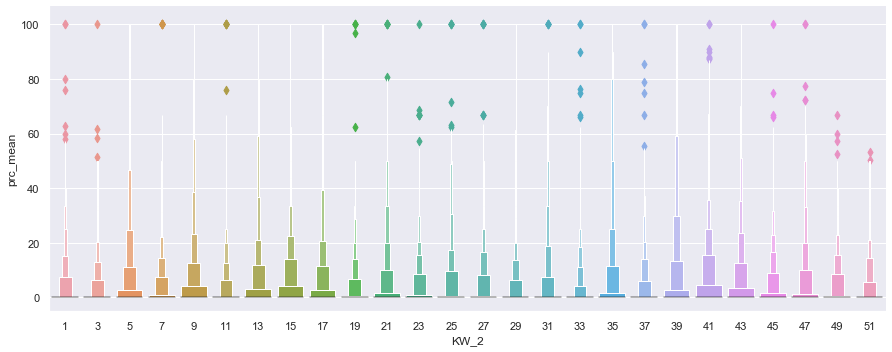

In [42]:
import seaborn as sns
%matplotlib inline

sns.catplot(
    data=ek_2w_prc_mean_stack, x="KW_2", y="prc_mean", aspect=2.5, kind="boxen"
)

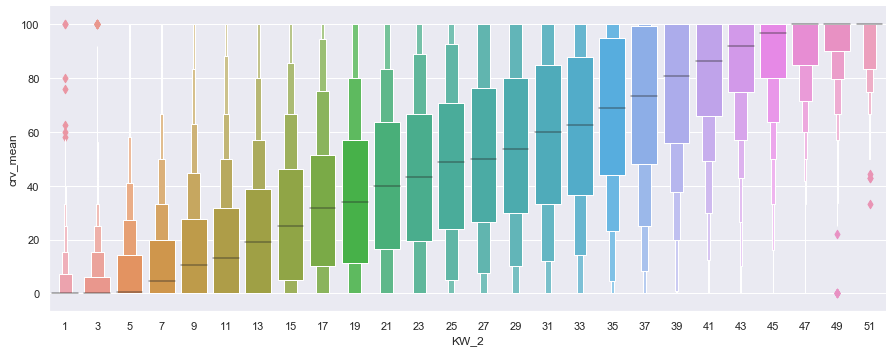

In [46]:
sns.catplot(
    data=ek_2w_crv_mean_stack, x="KW_2", y="crv_mean", aspect=2.5, kind="boxen"
)

### Cluster booking patterns (percentage of yearly sum)

Prepare data

In [147]:
X = ek_2w_prc_mean.to_numpy()

X_columns = ek_2w_prc_mean.columns

#### Normal KMeans

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

for n_clusters in range(5, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

For n_clusters = 5: Silhouette_score = 0.17682506165582113,  CH score = 533.4821777473247
For n_clusters = 6: Silhouette_score = 0.11855489325424093,  CH score = 517.0220591610981
For n_clusters = 7: Silhouette_score = 0.13662066119260827,  CH score = 499.4165459728453
For n_clusters = 8: Silhouette_score = 0.14953527709061792,  CH score = 508.36285484802977
For n_clusters = 9: Silhouette_score = 0.14387990422764135,  CH score = 543.1639156645448
For n_clusters = 10: Silhouette_score = 0.15881290554075514,  CH score = 542.5201840379153
For n_clusters = 11: Silhouette_score = 0.1674241359090093,  CH score = 557.791033280987
For n_clusters = 12: Silhouette_score = 0.19114625371658434,  CH score = 568.3310724793666
For n_clusters = 13: Silhouette_score = 0.19271292104516263,  CH score = 578.3380108307549
For n_clusters = 14: Silhouette_score = 0.20541864328253504,  CH score = 588.642036360538
For n_clusters = 15: Silhouette_score = 0.20923000958996574,  CH score = 581.68664576184
For n_cl

In [148]:
nkmeans = KMeans(n_clusters=15, random_state=0, verbose=1, n_jobs=-1)

prc_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

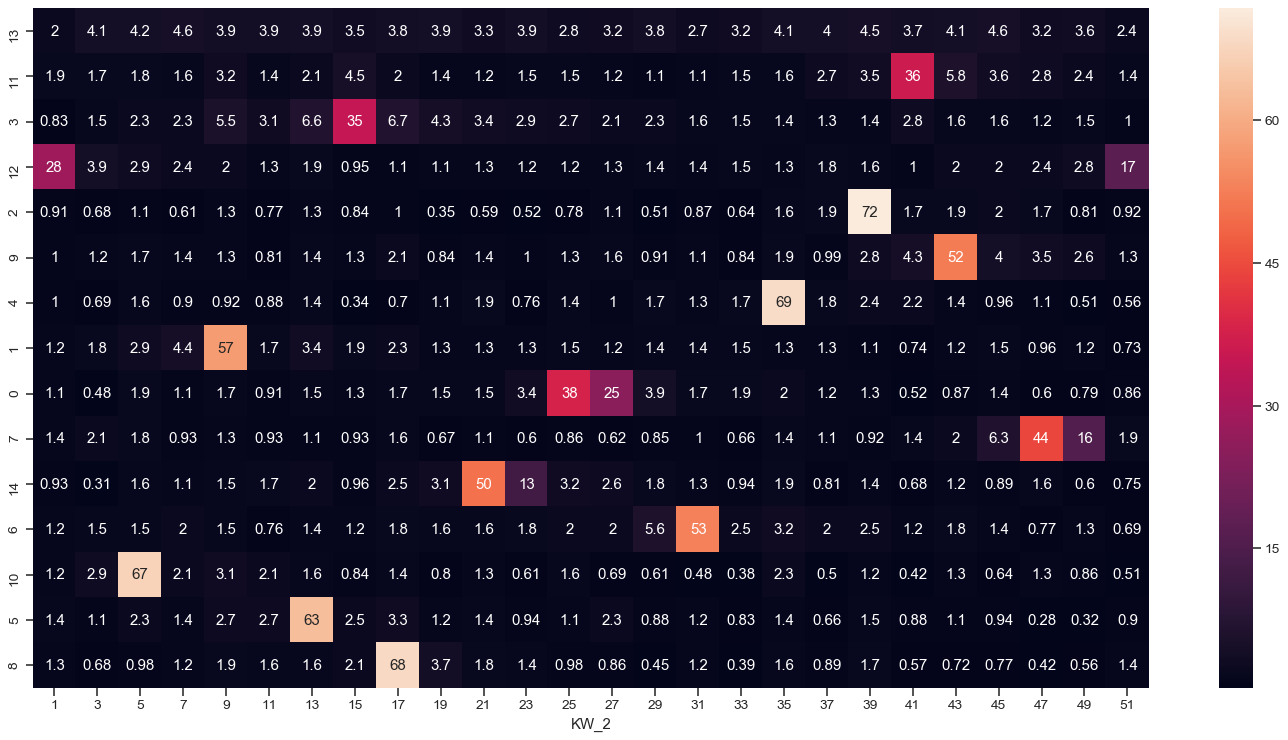

In [149]:
import seaborn as sns

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(prc_nkmeans_labels).value_counts().index
]

sns.heatmap(nkmeans_clusters, annot=True)

Cluster sizes

In [150]:
pd.Series(prc_nkmeans_labels).value_counts()

13    2534
11     528
3      443
12     306
2      292
9      267
4      260
1      255
0      254
7      251
14     238
6      237
10     233
5      201
8      198
dtype: int64

Plot scaled bookings by cluster

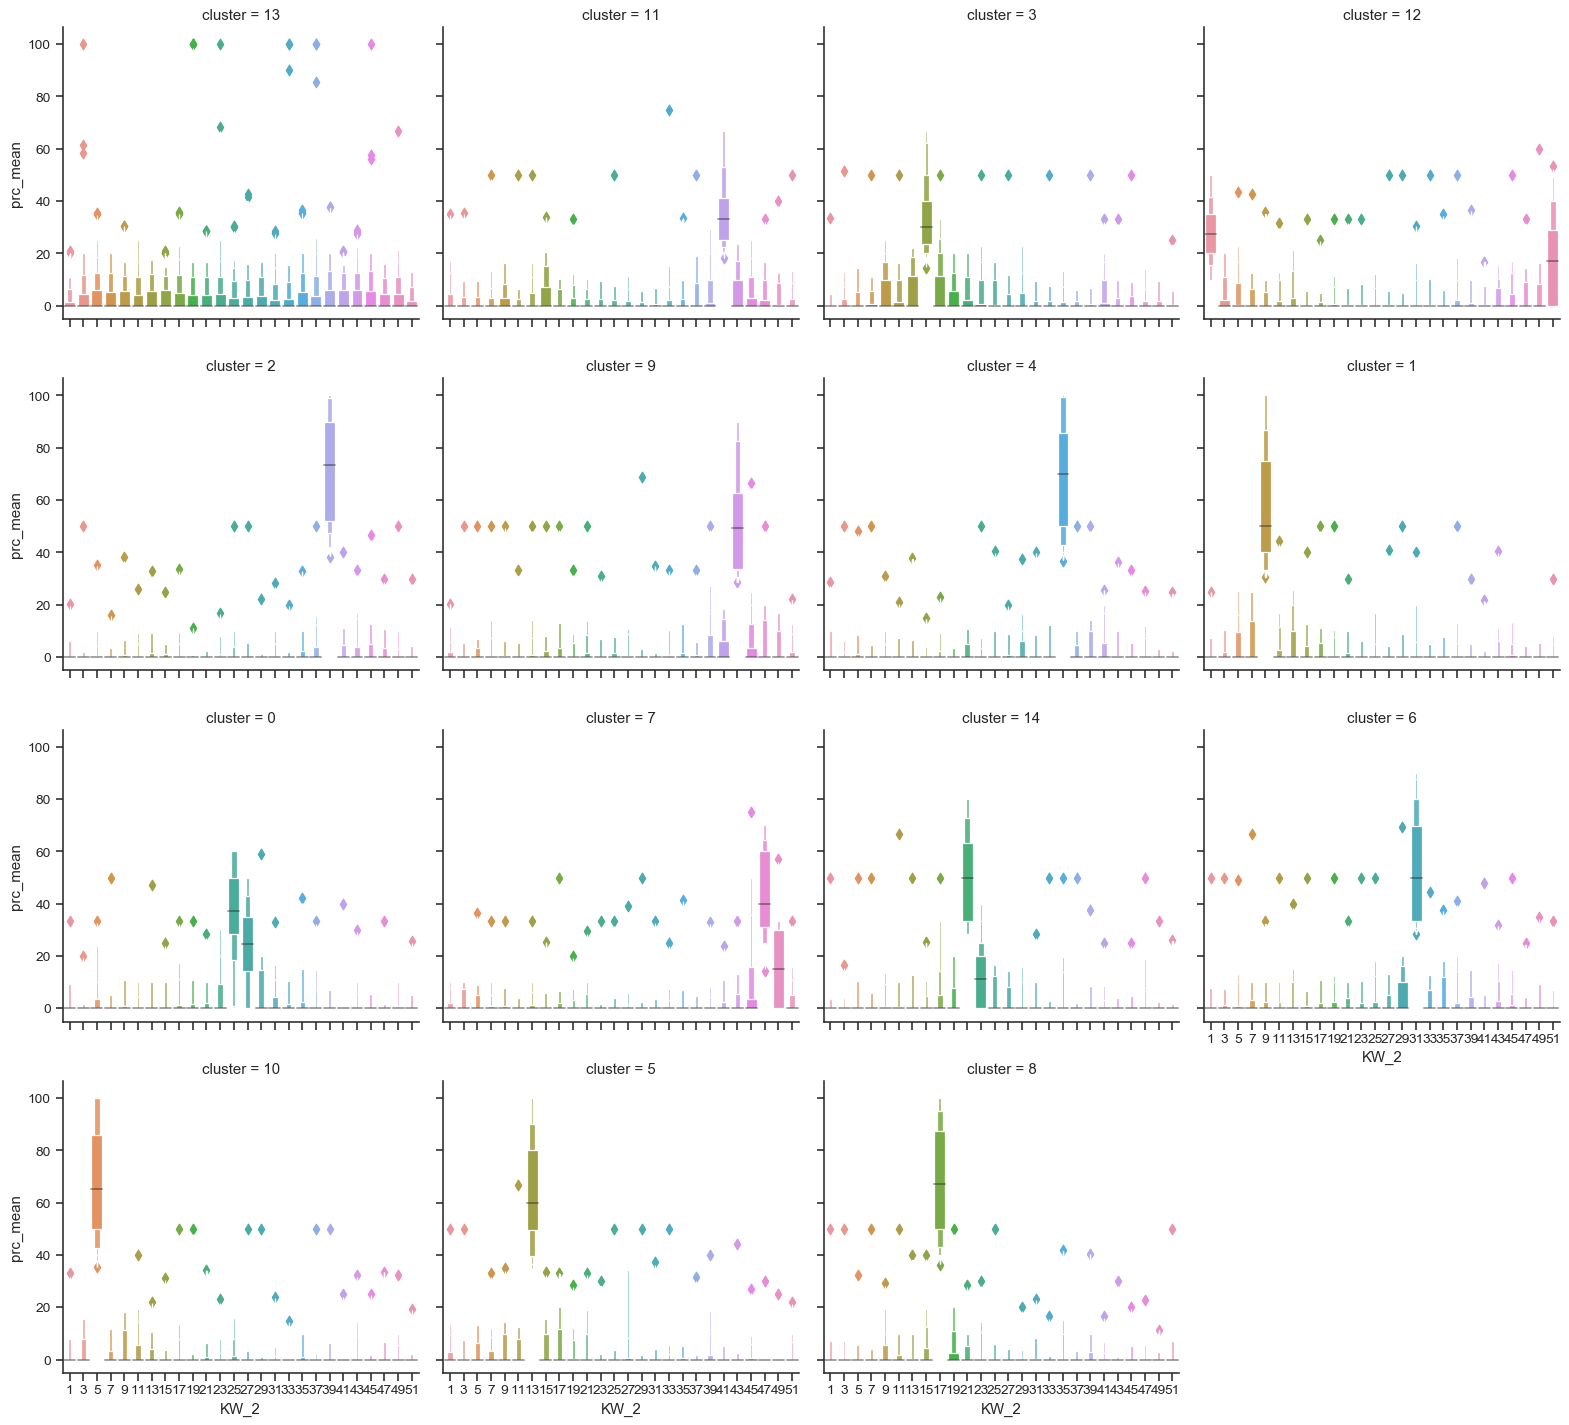

In [184]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=prc_nkmeans_labels, index=ek_2w_prc_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.1,
    kind="boxen",
    col="cluster",
    col_wrap=4,
    col_order=pd.Series(prc_nkmeans_labels).value_counts().index,  # order by cluster size
    height=4,
)

### Cluster booking patterns (cumulative percentage of yearly sum)

Prepare data

In [129]:
X = ek_2w_crv_mean.to_numpy()

X_columns = ek_2w_crv_mean.columns

#### Normal KMeans

In [74]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

for n_clusters in range(3, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

For n_clusters = 3: Silhouette_score = 0.27622337930292684,  CH score = 4236.73898205943
For n_clusters = 4: Silhouette_score = 0.23251441880067253,  CH score = 3606.8365028426074
For n_clusters = 5: Silhouette_score = 0.24561973287297184,  CH score = 3353.257921760772
For n_clusters = 6: Silhouette_score = 0.24142063437132416,  CH score = 3155.7841423766467
For n_clusters = 7: Silhouette_score = 0.23926363681462876,  CH score = 3024.7279013106913
For n_clusters = 8: Silhouette_score = 0.23691101805622897,  CH score = 2877.551724600581
For n_clusters = 9: Silhouette_score = 0.23368633435503974,  CH score = 2776.1421230356123
For n_clusters = 10: Silhouette_score = 0.2288891235980609,  CH score = 2640.281892654294
For n_clusters = 11: Silhouette_score = 0.22855660017964752,  CH score = 2548.8929047262177
For n_clusters = 12: Silhouette_score = 0.21986381198183602,  CH score = 2450.7699210033184
For n_clusters = 13: Silhouette_score = 0.21739695101881662,  CH score = 2371.979770208211
Fo

In [134]:
nkmeans = KMeans(n_clusters=10, random_state=0, verbose=1, n_jobs=-1)

crv_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

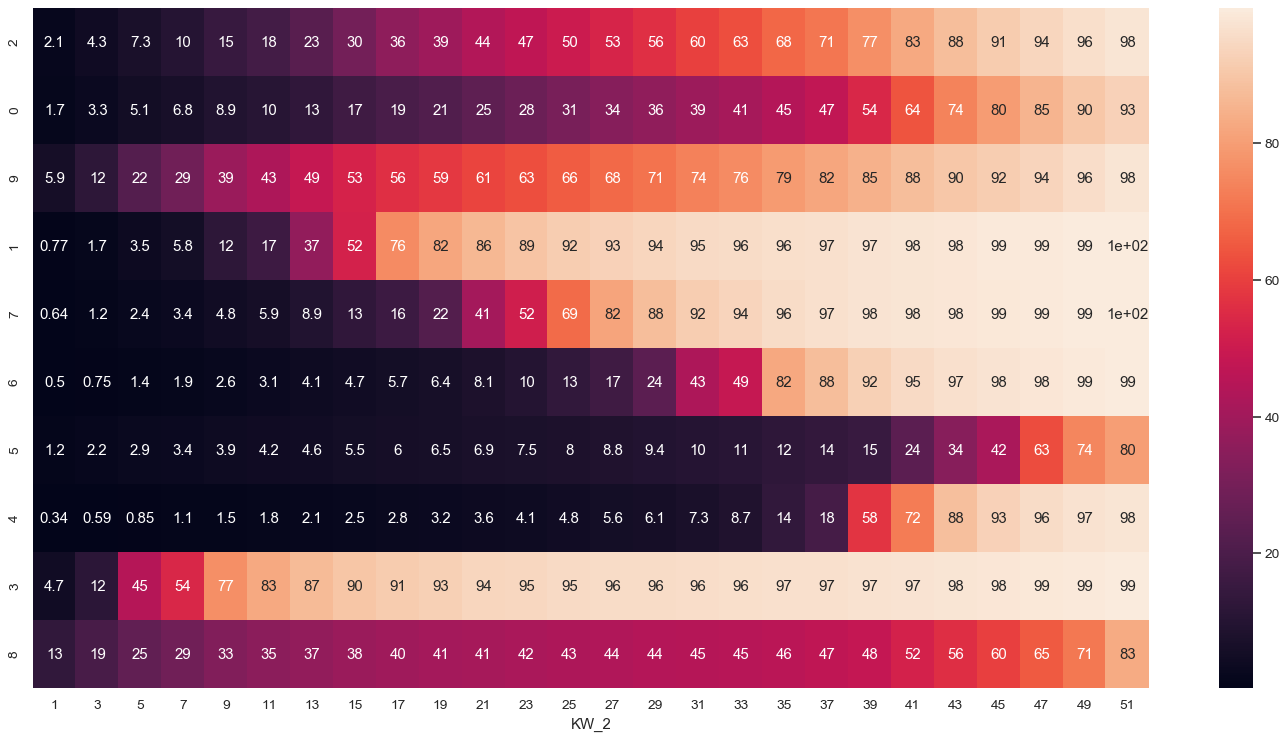

In [135]:
import seaborn as sns

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(crv_nkmeans_labels).value_counts().index
]

sns.heatmap(nkmeans_clusters, annot=True)

Cluster sizes

In [136]:
pd.Series(crv_nkmeans_labels).value_counts()

2    1171
0     833
9     770
1     667
7     588
6     541
5     525
4     516
3     464
8     422
dtype: int64

Plot scaled bookings by cluster

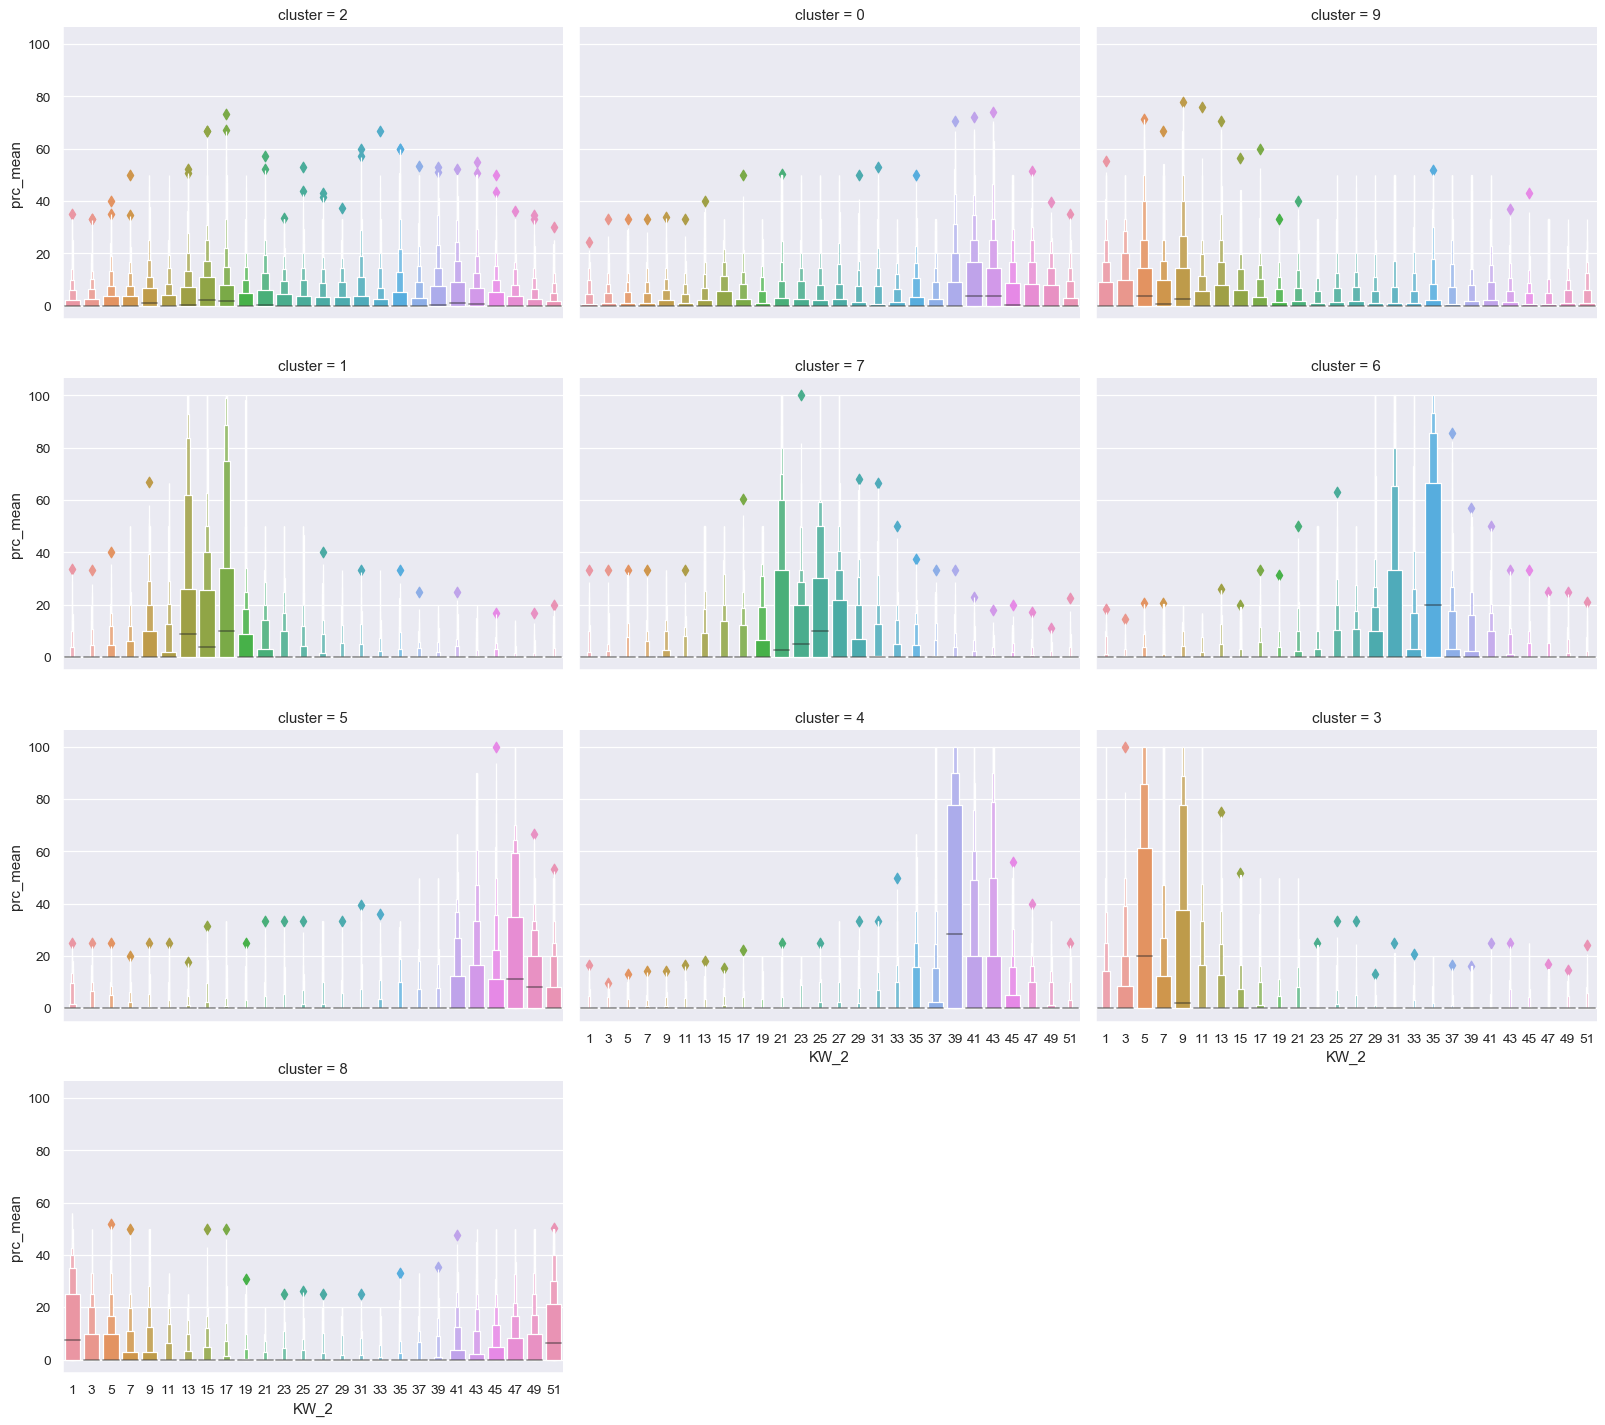

In [137]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=crv_nkmeans_labels, index=ek_2w_prc_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    col_order=pd.Series(crv_nkmeans_labels).value_counts().index, # order by cluster size
    height=4,
)

# PCA, LDA

### Prepare Data

In [170]:
X = ek_2w_crv_mean.to_numpy()
X_columns = ek_2w_crv_mean.columns
X_index = ek_2w_crv_mean.index

y = crv_nkmeans_labels

### Calculate standard PCA with 4 components

In [164]:
from sklearn.decomposition import PCA

In [178]:
pca = PCA(n_components=4, random_state=0)
X_pca = pca.fit_transform(X)

In [179]:
pca.explained_variance_ratio_

array([0.65059194, 0.15328579, 0.06305   , 0.0379854 ])

### Plot K-means clusters against principal components

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


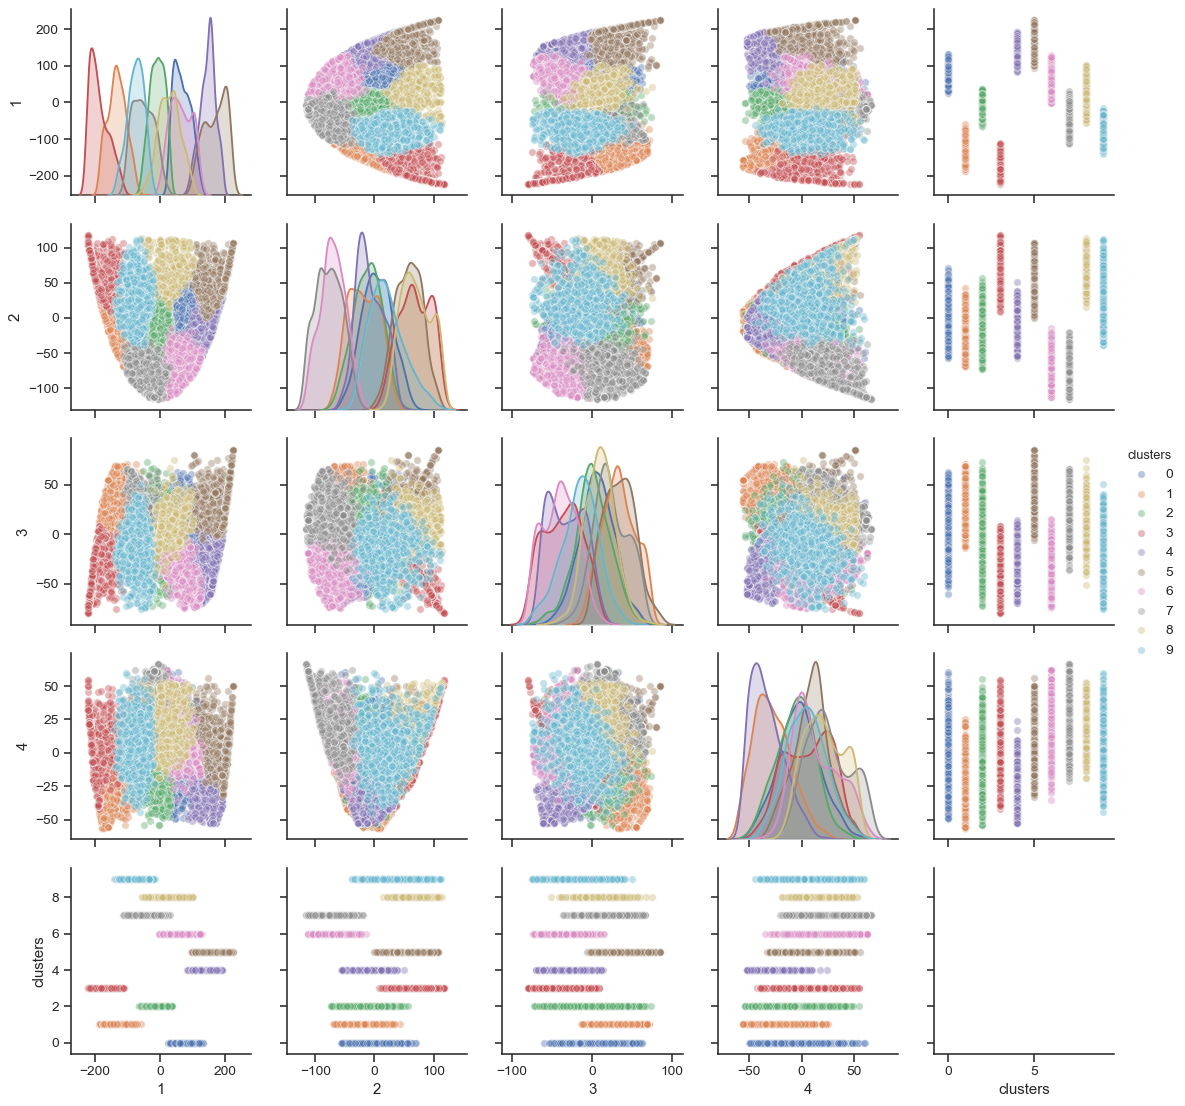

In [180]:
plot_data = pd.DataFrame(X_pca, index=X_index, columns=range(1, pca.n_components + 1))
plot_data["clusters"] = y
sns.set(style="ticks")
sns.pairplot(data=plot_data, hue="clusters", plot_kws={"alpha": 0.4})